In [144]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('data/merged_gw.csv', on_bad_lines='skip')
df_all = pd.read_csv("data/cleaned_merged_seasons.csv", on_bad_lines="skip")

/var/folders/9_/fcykl83s1dncqz69y6vx8b6w0000gn/T/ipykernel_35728/1769626954.py:11: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv("data/cleaned_merged_seasons.csv", on_bad_lines="skip")


In [100]:
# ICT compononents are dropped in favor of just keeping ICT_index
# Bonus dropped in favor of keeping just BPS
# Transfers in and out dropped in favor of keeping just transfers balance

to_drop = ['team_a_score','team_h_score', 'was_home', "modified", "round",
            "opponent_team", "kickoff_time", "fixture", "position", "team", "element", "creativity", "influence", "threat", "bonus"
            , "transfers_in", "transfers_out"]

In [10]:
df.columns

Index(['name', 'position', 'team', 'xP', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'expected_assists',
       'expected_goal_involvements', 'expected_goals',
       'expected_goals_conceded', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'influence', 'kickoff_time', 'minutes', 'modified',
       'opponent_team', 'own_goals', 'penalties_missed', 'penalties_saved',
       'red_cards', 'round', 'saves', 'selected', 'starts', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'yellow_cards',
       'GW'],
      dtype='object')

In [29]:
def rolling_calculator(df, weeks):
    result_df = df.copy()

    stat_cols = result_df.select_dtypes(include=[np.number]).columns.tolist()
    if "GW" in stat_cols:
        stat_cols.remove("GW")

    # Sort by player name and then GW
    result_df = result_df.sort_values(['name', 'GW'])
    
    # Loop through each stat column and calculate rolling totals per player
    for col in stat_cols:
        result_df[f'{col}_last_{weeks}_games'] = (
            result_df.groupby('name')[col]
            .rolling(window=weeks, min_periods=1)
            .sum()
            .reset_index(level=0, drop=True)
        )
    
    return result_df, stat_cols

In [101]:
df_stats_only = df.drop(columns=to_drop)

past_5, stat_cols = rolling_calculator(df_stats_only, 10)
past_5 = past_5.drop(columns=stat_cols)

Y = df["total_points"]
X = past_5.drop(columns=["name", "GW"])
X.sort_index()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

mae

1.4762233989875528

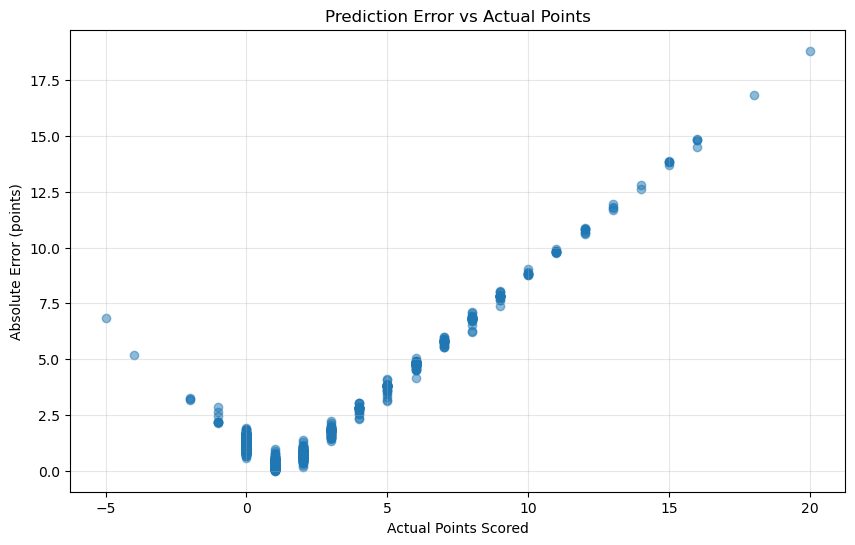

In [102]:
errors = np.abs(y_test - predictions)  # Absolute error

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, errors, alpha=0.5)
plt.xlabel('Actual Points Scored')
plt.ylabel('Absolute Error (points)')
plt.title('Prediction Error vs Actual Points')
plt.grid(True, alpha=0.3)
plt.show()

In [103]:
correlations = X.corrwith(Y).sort_values(ascending=False)

In [104]:
correlations

total_points_last_10_games                  0.591621
bps_last_10_games                           0.571461
ict_index_last_10_games                     0.535195
xP_last_10_games                            0.485172
expected_goal_involvements_last_10_games    0.477394
minutes_last_10_games                       0.467817
goals_scored_last_10_games                  0.462797
starts_last_10_games                        0.462571
clean_sheets_last_10_games                  0.459477
expected_goals_last_10_games                0.431013
assists_last_10_games                       0.410261
expected_assists_last_10_games              0.404424
expected_goals_conceded_last_10_games       0.391861
goals_conceded_last_10_games                0.364498
selected_last_10_games                      0.306836
yellow_cards_last_10_games                  0.237619
value_last_10_games                         0.177274
transfers_balance_last_10_games             0.104091
saves_last_10_games                         0.

In [116]:
fwd_to_drop = to_drop = ['team_a_score','team_h_score', 'was_home', "modified", "round",
            "opponent_team", "kickoff_time", "fixture", "position", "team", "element", "creativity", "influence", "threat", "bonus"
            , "transfers_in", "transfers_out", "clean_sheets", "penalties_saved", "goals_conceded", "expected_goals_conceded", "penalties_saved", "saves"]

In [117]:
df_fwd = df[df['position'] == 'FWD']
df_fwd = df_fwd.drop(columns=fwd_to_drop)

fwd_past_5, stat_cols = rolling_calculator(df_fwd, 5)
fwd_past_5 = fwd_past_5.drop(columns=stat_cols)


Y = df_fwd["total_points"]
X = fwd_past_5.drop(columns=["name", "GW"])
X.sort_index()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
correlations = X.corrwith(Y).sort_values(ascending=False)

mae


1.9647257385640373

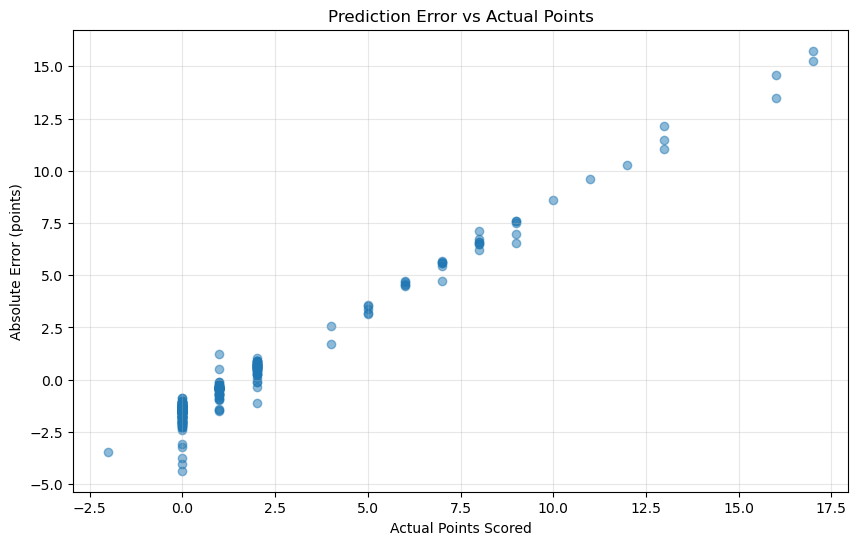

In [121]:
errors = y_test - predictions  # Absolute error

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, errors, alpha=0.5)
plt.xlabel('Actual Points Scored')
plt.ylabel('Absolute Error (points)')
plt.title('Prediction Error vs Actual Points')
plt.grid(True, alpha=0.3)
plt.show()

In [118]:
correlations

total_points_last_5_games                  0.692843
bps_last_5_games                           0.676753
goals_scored_last_5_games                  0.648559
ict_index_last_5_games                     0.647129
expected_goal_involvements_last_5_games    0.595100
minutes_last_5_games                       0.576168
expected_goals_last_5_games                0.575255
starts_last_5_games                        0.564265
xP_last_5_games                            0.559881
assists_last_5_games                       0.440071
expected_assists_last_5_games              0.422154
selected_last_5_games                      0.357550
value_last_5_games                         0.280543
yellow_cards_last_5_games                  0.243698
transfers_balance_last_5_games             0.126699
penalties_missed_last_5_games              0.094438
own_goals_last_5_games                    -0.013435
red_cards_last_5_games                    -0.035647
dtype: float64

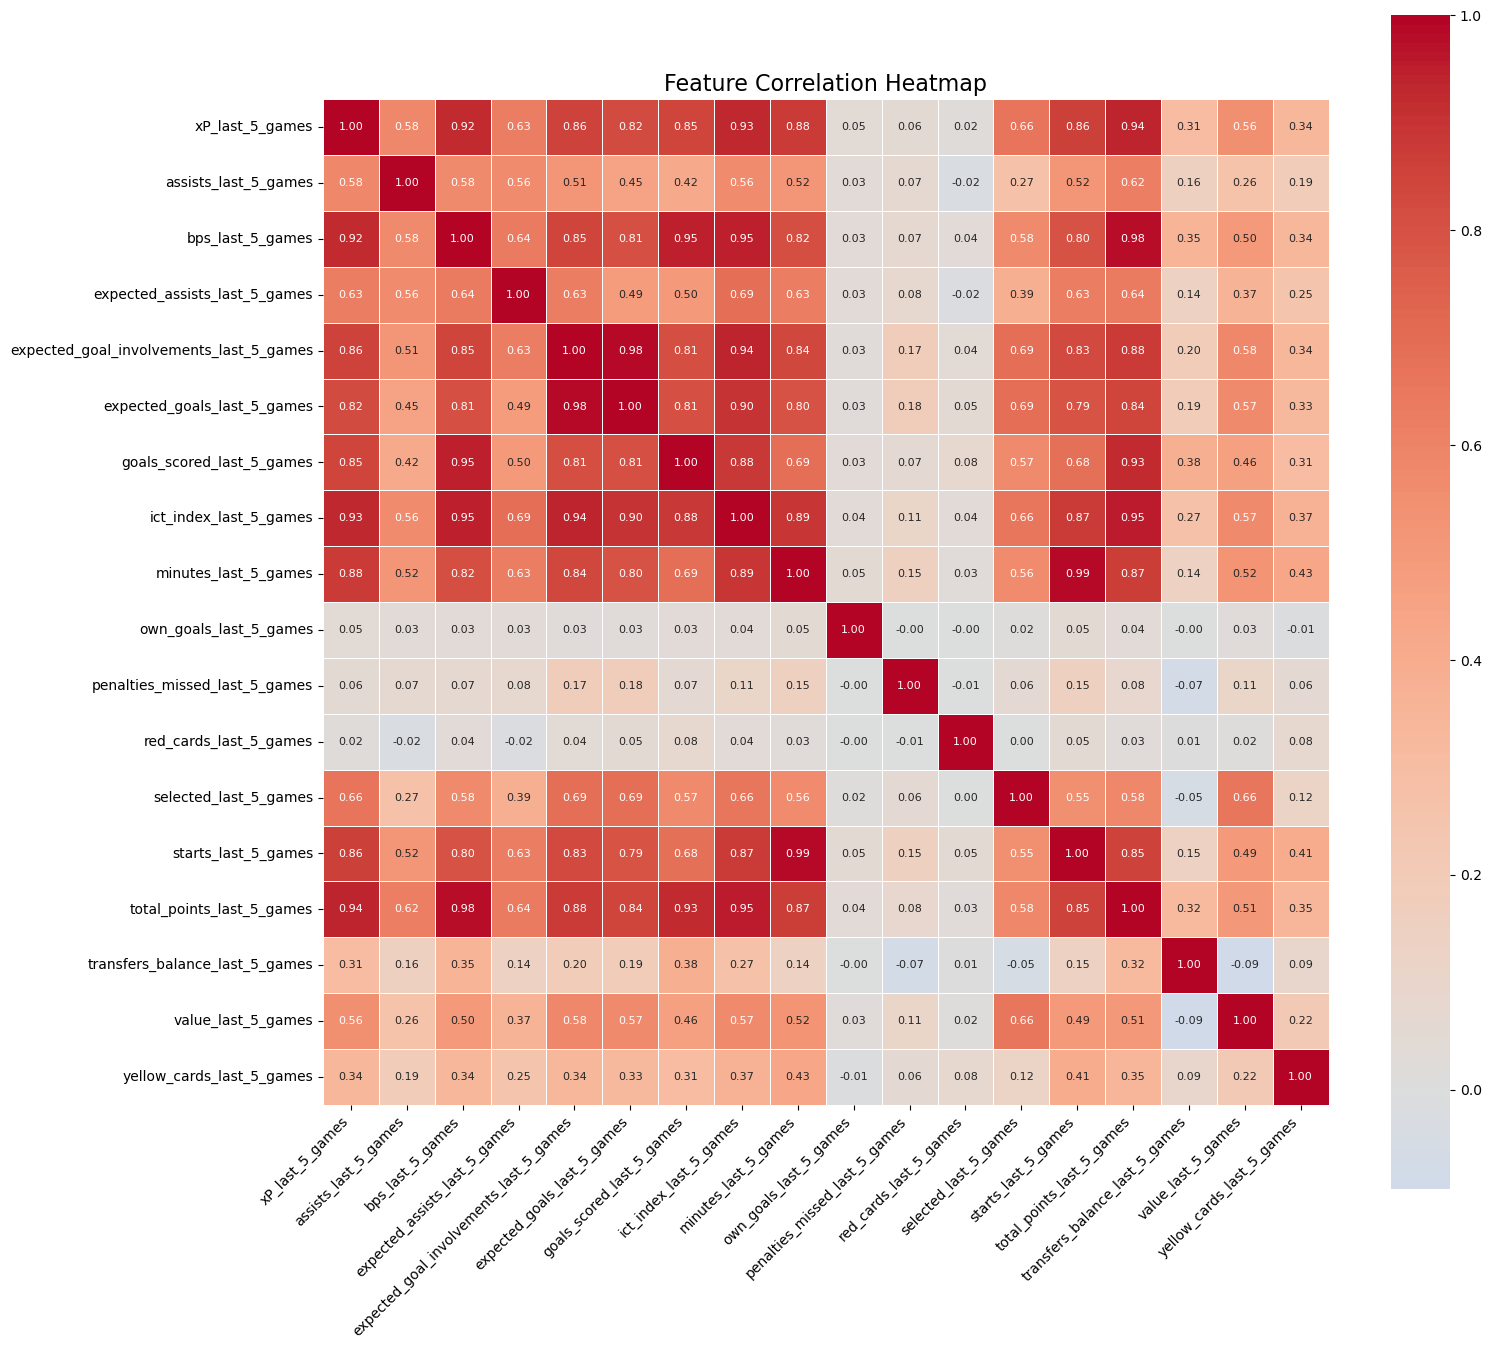

In [119]:
correlation_matrix = X.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.2f', square=True, linewidths=0.5, 
            annot_kws={'size': 8})  # Smaller text
plt.title('Feature Correlation Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
def show_prediction(player_name, game_week, results_df):
    """Show prediction details for a specific game"""
    result = results_df[(results_df['player_name'] == player_name) & 
                        (results_df['GW'] == game_week)]
    
    if len(result) == 0:
        print(f"No data found for {player_name} in GW{game_week}")
        return
    
    pred = result['predicted_points'].values[0]
    actual = result['actual_points'].values[0]
    error = result['error'].values[0]
    
    print(f"\n{'='*50}")
    print(f"Player: {player_name} | Game Week: {game_week}")
    print(f"{'='*50}")
    print(f"Predicted Points: {pred:.2f}")
    print(f"Actual Points:    {actual:.2f}")
    print(f"Error:            {error:.2f}")
    print(f"{'='*50}\n")

# Usage


show_prediction('Haaland', 10, results_df)

In [178]:
to_drop_all_fwd = to_drop = ['team_a_score','team_h_score', 'was_home', "round",
            "opponent_team", "kickoff_time", "fixture", "position","element", "creativity", "influence", "threat", "bonus"
            , "transfers_in", "transfers_out", "clean_sheets", "penalties_saved", "goals_conceded", "penalties_saved", "saves",
             "season_x", "team_x" , "opp_team_name", "red_cards", "penalties_missed", "goals_scored", "yellow_cards"]



In [164]:
df_all = df_all[df_all['minutes'] > 0]

In [124]:
df_all.columns

Index(['season_x', 'name', 'position', 'team_x', 'assists', 'bonus', 'bps',
       'clean_sheets', 'creativity', 'element', 'fixture', 'goals_conceded',
       'goals_scored', 'ict_index', 'influence', 'kickoff_time', 'minutes',
       'opponent_team', 'opp_team_name', 'own_goals', 'penalties_missed',
       'penalties_saved', 'red_cards', 'round', 'saves', 'selected',
       'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'GW'],
      dtype='object')

In [174]:
df_fwd_all = df_all[df_all['position'] == 'FWD']
df_fwd_all = df_fwd_all.drop(columns=to_drop_all_fwd)

fwd_all_past_5, stat_cols = rolling_calculator(df_fwd_all, 5)
fwd_all_past_5 = fwd_all_past_5.drop(columns=stat_cols)


Y = df_fwd_all["total_points"]
X = fwd_all_past_5.drop(columns=["name", "GW"])
X.sort_index()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

y_train_log = np.sign(y_train) * np.log1p(np.abs(y_train))
y_test_log = np.sign(y_test) * np.log1p(np.abs(y_test))


model = LinearRegression()
model.fit(X_train, y_train)

predictions_log = model.predict(X_test)
predictions = np.sign(predictions_log) * np.expm1(np.abs(predictions_log))

mae = mean_absolute_error(y_test, predictions)
correlations = X.corrwith(Y).sort_values(ascending=False)

mae

ranges = [
    (0, 3, "Low scorers (0-3 pts)"),
    (3, 6, "Medium scorers (3-6 pts)"),
    (6, 10, "High scorers (6-10 pts)"),
    (10, 100, "Elite performances (10+ pts)")
]

for low, high, label in ranges:
    mask = (y_test >= low) & (y_test < high)
    if mask.sum() > 0:  # Check if any games in this range
        mae = mean_absolute_error(y_test[mask], predictions[mask])
        count = mask.sum()
        print(f"{label}: MAE = {mae:.2f} ({count} games)")

Low scorers (0-3 pts): MAE = 21.55 (1073 games)
Medium scorers (3-6 pts): MAE = 18.70 (138 games)
High scorers (6-10 pts): MAE = 15.46 (218 games)
Elite performances (10+ pts): MAE = 10.33 (103 games)


In [185]:

df_fwd_all = df_all[df_all['position'] == 'FWD']
df_fwd_all = df_fwd_all.drop(columns=to_drop_all_fwd)

fwd_all_past_5, stat_cols = rolling_calculator(df_fwd_all, 5)
fwd_all_past_5 = fwd_all_past_5.drop(columns=stat_cols)

Y = df_fwd_all["total_points"]
X = fwd_all_past_5.drop(columns=["name", "GW"])
X.sort_index()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Random Forest - no log transformation needed!
model = RandomForestRegressor(
    n_estimators=100, 
    max_depth=10,
    min_samples_split=20,
    random_state=42
)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
correlations = X.corrwith(Y).sort_values(ascending=False)

mae

2.6007575303814576

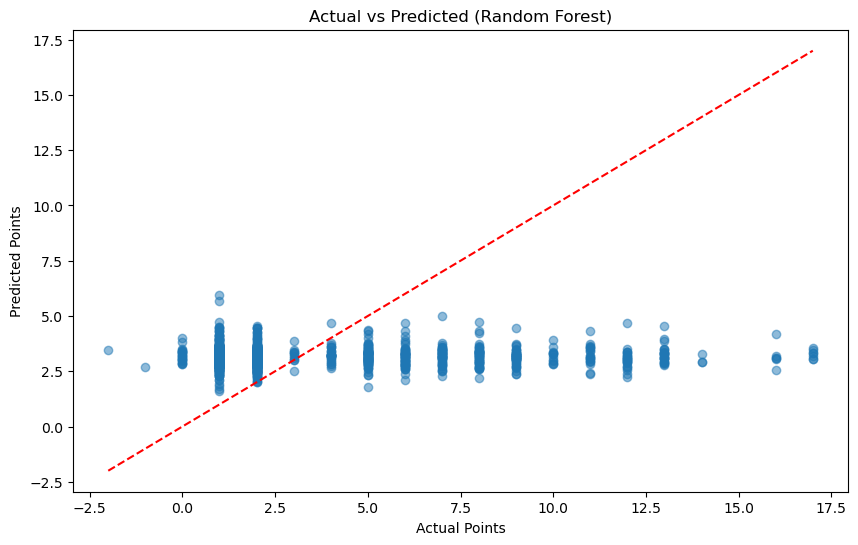

In [186]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual vs Predicted (Random Forest)')
plt.show()

In [187]:
# 1. Check the MAE breakdown for Random Forest
ranges = [
    (0, 3, "Low scorers (0-3 pts)"),
    (3, 6, "Medium scorers (3-6 pts)"),
    (6, 10, "High scorers (6-10 pts)"),
    (10, 100, "Elite performances (10+ pts)")
]

print("Random Forest MAE by Range:")
for low, high, label in ranges:
    mask = (y_test >= low) & (y_test < high)
    if mask.sum() > 0:
        mae = mean_absolute_error(y_test[mask], predictions[mask])
        count = mask.sum()
        avg_pred = predictions[mask].mean()
        print(f"{label}: MAE = {mae:.2f} | Avg prediction = {avg_pred:.2f} ({count} games)")

# 2. Check what features you're actually using
print(f"\nNumber of features: {X_train.shape[1]}")
print("\nFeatures in model:")
print(X_train.columns.tolist())

# 3. Check prediction range
print(f"\nPrediction range: {predictions.min():.2f} to {predictions.max():.2f}")
print(f"Actual range: {y_test.min():.2f} to {y_test.max():.2f}")

# 4. Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Features:")
print(feature_importance.head(10))

Random Forest MAE by Range:
Low scorers (0-3 pts): MAE = 1.77 | Avg prediction = 3.17 (1073 games)
Medium scorers (3-6 pts): MAE = 1.46 | Avg prediction = 3.21 (138 games)
High scorers (6-10 pts): MAE = 4.25 | Avg prediction = 3.17 (218 games)
Elite performances (10+ pts): MAE = 9.24 | Avg prediction = 3.19 (103 games)

Number of features: 9

Features in model:
['assists_last_5_games', 'bps_last_5_games', 'ict_index_last_5_games', 'minutes_last_5_games', 'own_goals_last_5_games', 'selected_last_5_games', 'total_points_last_5_games', 'transfers_balance_last_5_games', 'value_last_5_games']

Prediction range: 1.63 to 5.93
Actual range: -2.00 to 17.00

Top 10 Features:
                          feature  importance
7  transfers_balance_last_5_games    0.197260
5           selected_last_5_games    0.178650
3            minutes_last_5_games    0.144499
2          ict_index_last_5_games    0.140211
8              value_last_5_games    0.129038
1                bps_last_5_games    0.112399
6   

In [176]:
for low, high, label in ranges:
    mask = (y_test >= low) & (y_test < high)
    if mask.sum() > 0:
        mae = mean_absolute_error(y_test[mask], predictions[mask])
        count = mask.sum()
        print(f"{label}: MAE = {mae:.2f} ({count} games)")

Low scorers (0-3 pts): MAE = 1.77 (1073 games)
Medium scorers (3-6 pts): MAE = 1.45 (138 games)
High scorers (6-10 pts): MAE = 4.25 (218 games)
Elite performances (10+ pts): MAE = 9.24 (103 games)


In [189]:
df_fwd_all = df_all[df_all['position'] == 'FWD']
df_fwd_all = df_fwd_all[df_fwd_all['minutes'] > 0]  # Filter 0 minutes
df_fwd_all = df_fwd_all.drop(columns=to_drop_all_fwd)

fwd_all_past_5, stat_cols = rolling_calculator(df_fwd_all, 5)
fwd_all_past_5 = fwd_all_past_5.drop(columns=stat_cols)

Y = df_fwd_all["total_points"]
X = fwd_all_past_5.drop(columns=["name", "GW"])
X.sort_index()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Get values for PPV calculation
value_train = df_fwd_all.loc[y_train.index, 'value']
value_test = df_fwd_all.loc[y_test.index, 'value']

# Define weighting schemes
weighting_schemes = {
    "No weights (baseline)": None,
    "Linear (medium)": 1 + (np.abs(y_train) / 5),
    "Exponential (strong)": np.exp(np.abs(y_train) / 10),
    "Step function (extreme)": np.where(np.abs(y_train) >= 10, 10, 1)
}

# Test each weighting scheme
ranges = [
    (0, 3, "Low scorers (0-3 pts)"),
    (3, 6, "Medium scorers (3-6 pts)"),
    (6, 10, "High scorers (6-10 pts)"),
    (10, 100, "Elite performances (10+ pts)")
]

for scheme_name, weights in weighting_schemes.items():
    print(f"\n{'='*60}")
    print(f"{scheme_name}")
    print(f"{'='*60}")
    
    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train, sample_weight=weights)
    
    # Predict
    predictions = model.predict(X_test)
    
    # Overall MAE
    mae = mean_absolute_error(y_test, predictions)
    print(f"Overall MAE: {mae:.2f}")
    
    # MAE by range
    for low, high, label in ranges:
        mask = (y_test >= low) & (y_test < high)
        if mask.sum() > 0:
            mae_range = mean_absolute_error(y_test[mask], predictions[mask])
            count = mask.sum()
            print(f"  {label}: MAE = {mae_range:.2f} ({count} games)")
    
    # PPV Analysis
    print("\n--- PPV Analysis ---")
    
    # Calculate PPV
    predicted_ppv = predictions / value_test.values
    actual_ppv = y_test.values / value_test.values
    
    # PPV MAE
    ppv_mae = mean_absolute_error(actual_ppv, predicted_ppv)
    print(f"PPV MAE: {ppv_mae:.3f}")
    
    # PPV Rank Correlation
    from scipy.stats import spearmanr
    ppv_corr, _ = spearmanr(predicted_ppv, actual_ppv)
    print(f"PPV Rank Correlation: {ppv_corr:.3f}")
    
    # Top 10 PPV overlap
    results_df = pd.DataFrame({
        'predicted_ppv': predicted_ppv,
        'actual_ppv': actual_ppv
    })
    
    top_10_predicted = set(results_df.nlargest(10, 'predicted_ppv').index)
    print(top_10_predicted)
    top_10_actual = set(results_df.nlargest(10, 'actual_ppv').index)
    print(top_10_actual)
    overlap = len(top_10_predicted & top_10_actual)
    print(f"Top 10 PPV Overlap: {overlap}/10 players")
    
    # Signed error
    signed_errors = predictions - y_test
    print(f"\nMean Signed Error: {signed_errors.mean():.2f}")
    
    # Show top 5 features for this scheme
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': model.coef_
    }).sort_values('coefficient', ascending=False)
    
    print("\nTop 5 Features:")
    print(feature_importance.head(5)[['feature', 'coefficient']])


No weights (baseline)
Overall MAE: 2.60
  Low scorers (0-3 pts): MAE = 1.76 (1073 games)
  Medium scorers (3-6 pts): MAE = 1.48 (138 games)
  High scorers (6-10 pts): MAE = 4.27 (218 games)
  Elite performances (10+ pts): MAE = 9.29 (103 games)

--- PPV Analysis ---
PPV MAE: 0.040
PPV Rank Correlation: 0.033
{293, 1351, 1178, 601, 1044, 1141, 857, 826, 891, 764}
{1056, 513, 486, 779, 653, 946, 147, 789, 504, 1531}
Top 10 PPV Overlap: 0/10 players

Mean Signed Error: -0.12

Top 5 Features:
                  feature  coefficient
4  own_goals_last_5_games     0.157852
1        bps_last_5_games     0.004653
2  ict_index_last_5_games     0.002216
8      value_last_5_games     0.000915
3    minutes_last_5_games     0.000093

Linear (medium)
Overall MAE: 3.19
  Low scorers (0-3 pts): MAE = 3.12 (1073 games)
  Medium scorers (3-6 pts): MAE = 0.57 (138 games)
  High scorers (6-10 pts): MAE = 2.91 (218 games)
  Elite performances (10+ pts): MAE = 7.96 (103 games)

--- PPV Analysis ---
PPV MAE: 

In [161]:
for low, high, label in ranges:
    mask = (y_test >= low) & (y_test < high)
    if mask.sum() > 0:
        mae = mean_absolute_error(y_test[mask], predictions[mask])
        count = mask.sum()
        print(f"{label}: MAE = {mae:.2f} ({count} games)")

Low scorers (0-3 pts): MAE = 2.13 (2863 games)
Medium scorers (3-6 pts): MAE = 1.90 (132 games)
High scorers (6-10 pts): MAE = 4.68 (217 games)
Elite performances (10+ pts): MAE = 10.88 (85 games)


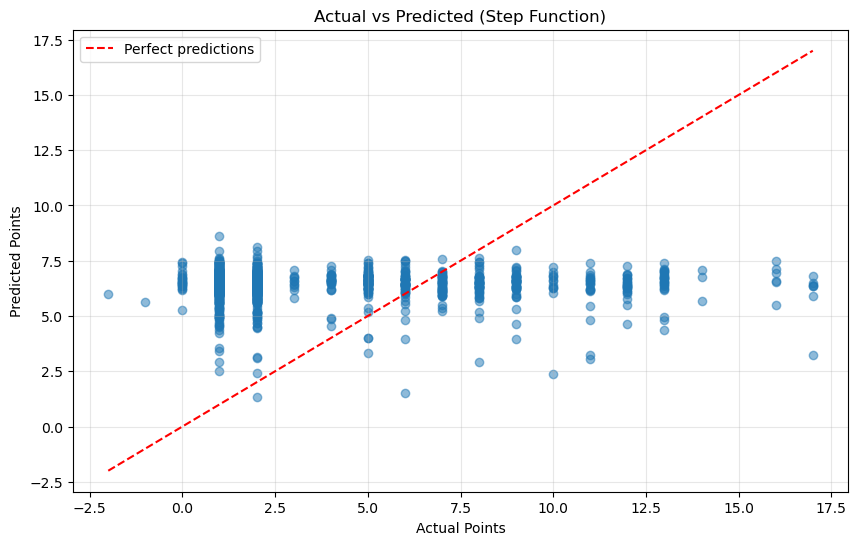

In [182]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', label='Perfect predictions')
plt.xlabel('Actual Points')
plt.ylabel('Predicted Points')
plt.title('Actual vs Predicted (Step Function)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()